## 1. Regresiones
 Con los datos presentes en la carpeta Datos/Forecasting de la clase 2 construyan un modelo de regresión lineal que les permita realizar una predicción futura de la variable Sales quantity. Experimenten con distintas transformaciones de los datos, regresiones polinómicas u otras técnicas que las utilizadas en clase para obtener el mejor modelo posible en testing.

In [1]:
# Importamos las librerías necesarias
import numpy as np
from numpy.linalg import inv, norm
import pandas as pd
import matplotlib.pyplot as plt
import random

from linear_regression import LinReg

In [2]:
# Guardamos los datos en un DataFrame, y le decimos a pandas
# que la primer columna es del tipo DateTime
Data = pd.read_csv('data/month_value_1.csv', parse_dates=[0], date_format='%d.%m.%Y')
Data.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,2015-01-01,1.601007e+07,12729.0,1257.763541,30024676.0
1,2015-02-01,1.580759e+07,11636.0,1358.507000,30024676.0
2,2015-03-01,2.204715e+07,15922.0,1384.697024,30024676.0
3,2015-04-01,1.881458e+07,15227.0,1235.606705,30024676.0
4,2015-05-01,1.402148e+07,8620.0,1626.621765,30024676.0


,Period,Sales_quantity
0,2015-01-01,12729.0
1,2015-02-01,11636.0
2,2015-03-01,15922.0
3,2015-04-01,15227.0
4,2015-05-01,8620.0


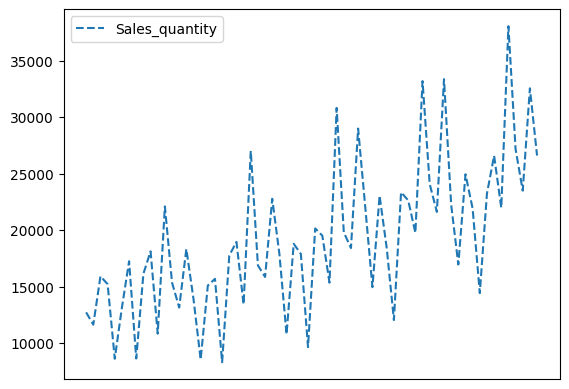

In [3]:
# Actualizamos Data a un subset del original, que contenga sólo las 
# columnas que nos interesan
Data = Data[['Period', 'Sales_quantity']]

# Ordenamos los datos
Data = Data.sort_values(by='Period').reset_index(drop=True)

# Graficamos los datos
Data.plot(y='Sales_quantity', xticks=[], style='--')

Data.head()

<Axes: >

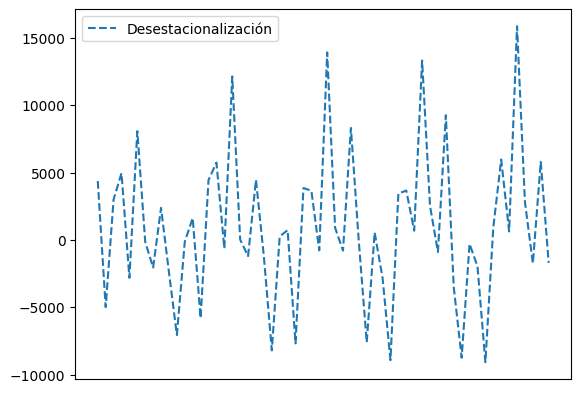

In [4]:
# Aplicamos una transformación básica de media móvil
Data['Media_movil'] = Data['Sales_quantity'].shift(1).rolling(window=6, center=False).mean()
Data['Desestacionalización'] = Data['Sales_quantity'] - Data['Media_movil']

# Graficamos el resultado
Data.plot(y='Desestacionalización', xticks=[], style='--')

In [5]:
# Con el objetivo de intentar capturar la componente estacional,
# agregamos variables dummy para cada mes
month_dummies = pd.get_dummies(Data['Period'].dt.month_name(), prefix='Month', drop_first=True)
month_dummies = month_dummies.astype(int)
Data = pd.concat([Data, month_dummies], axis=1)

# Nos quedamos con los 5 valores anteriores, 
lags = []
for i in range(1, 6):
    Data[f'Lag_{i}'] = Data['Desestacionalización'].shift(i)
    lags.append(f'Lag_{i}')

# Suprimimos los registros con valores nulos
Data.dropna(inplace=True)

# Debido a la baja cantidad de datos, entrenaremos el modelo con todos los datos
print(len(Data))

53


In [7]:
# Definimos el conjunto de variables predictoras y los targets
months = ['Month_August', 'Month_December', 'Month_February', 'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May', 'Month_November', 'Month_October', 'Month_September']
vars = months + lags 
X = Data[vars]
y = Data['Desestacionalización']

# Entreno el modelo
Regresion = LinReg(verbose=True)
Regresion.fit(X,y)

# Imprimo el error cuadrático medio
print(Regresion.score(X,y))

# Imprimo los parámetros
params = Regresion.get_params()
for i in range(len(params)-1):
    print(f'{vars[i]}: {params[i]}')

Model trained!
1337603.3350770706
Month_August: 44.35190169552949
Month_December: -4292.497040828183
Month_February: 9817.02021642748
Month_January: -1033.1174821439795
Month_July: -3547.352375314887
Month_June: 1833.5166034076583
Month_March: 217.64416229872631
Month_May: 5242.758977096841
Month_November: -3515.1644141952233
Month_October: 271.56447099844036
Month_September: 2514.371989366966
Lag_1: 1703.9045020542335
Lag_2: 0.13356448304462626
Lag_3: 0.15386942749826102
Lag_4: 0.19844961571495617
Lag_5: -0.23053794891842


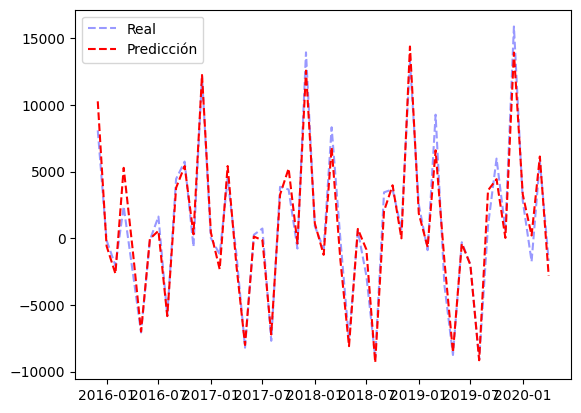

,Desestacionalización,Prediccion
count,53.000000,53.000000
mean,950.808176,950.808175
std,5749.080024,5629.261736
min,-9087.333333,-9315.912597
25%,-1745.500000,-1699.112605
50%,256.500000,127.038496
75%,3667.500000,3971.919346
max,15877.500000,14376.459022


In [8]:
# Realizo la predicción
Data['Prediccion'] = Regresion.predict(X)

# Miro las predicciones
plt.plot(Data["Period"], Data["Desestacionalización"],'--',c='Blue',label='Real', alpha=0.4)
plt.plot(Data["Period"], Regresion.predict(X),'--',c='Red',label='Predicción')
plt.legend()
plt.show()

# Imprimo el resumen de las predicciones
Data[['Desestacionalización', 'Prediccion']].describe()